# CIDM Lab 1 — P1→P3 (Notebook Only, Code You Can Edit)
**Course:** P170M109 Computational Intelligence and Decision Making  
**This notebook covers:**  
- **P1**: Input analysis & preprocessing (before/after)  
- **P2**: Modeling with **KNN**, **Decision Tree**, **Random Forest**  
- **P3**: Hyperparameter selection & final results



In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
plt.rcParams['figure.figsize'] = (7, 4)

## P1. Data analysis and preprocessing
### 1) Load data (robust file search)

In [17]:
def find_file_upwards(filename: str, start: Path | None = None) -> Path:
    """Search for `filename` in the current working directory and its parents.
    Returns the full Path if found; raises FileNotFoundError otherwise."""
    start = (start or Path.cwd()).resolve()
    for base in [start, *start.parents]:
        candidate = base / filename
        if candidate.is_file():
            return candidate
    raise FileNotFoundError(
        f"Could not find '{filename}' starting from {start}.\n"
        f"Current working directory: {Path.cwd()}\n"
        "Make sure the filename is correct and the file exists."
    )

# Common dataset names (100K preferred, then 10K)
CANDIDATES = [
    "apartments_for_rent_classified_100K.csv",
    "apartments_for_rent_classified_10K.csv",
]

data_path = None
for name in CANDIDATES:
    try:
        data_path = find_file_upwards(name)
        print("Loaded file:", data_path)
        break
    except FileNotFoundError:
        pass

# New (more robust and readable):
candidates = [
    "apartments_for_rent_classified_10K.csv",
    "/mnt/data/apartments_for_rent_classified_10K.csv",
    "apartments_for_rent_classified_100K.csv",
    "/mnt/data/apartments_for_rent_classified_100K.csv",
]
data_path = next((str(p) for p in map(Path, candidates) if p.exists()), None)
if data_path is None:
    raise FileNotFoundError("Could not find any of the expected CSV files. Checked: " + ", ".join(candidates))

# Try UTF-8 first, then fall back to Windows-1252. Files are semicolon-delimited per dataset samples.
try:
    df_raw = pd.read_csv(data_path, sep=";", encoding="utf-8")
except UnicodeDecodeError:
    df_raw = pd.read_csv(data_path, sep=";", encoding="cp1252")

print("Raw shape:", df_raw.shape)
df_raw.head(3)

Loaded file: C:\Users\Rokas\Documents\KTU\KTU P170M109 Computational Intelligence and Decision Making\Lab 1\apartments_for_rent_classified_100K.csv
Raw shape: (10000, 22)


,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,pets_allowed,price,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,NaN,790,$790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,NaN,425,$425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,NaN,1390,"$1,390",Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410


### 2) Determine feature types & Data Quality Reports (numeric vs categorical)

In [18]:
def infer_feature_types(df: pd.DataFrame):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in df.columns if c not in num_cols]
    return num_cols, cat_cols

def dqr_numeric(df: pd.DataFrame, cols):
    rows = []
    for c in cols:
        s = pd.to_numeric(df[c], errors="coerce")
        n = len(s); miss = s.isna().sum()
        desc = s.describe()
        rows.append({
            "feature": c, "n": n, "missing": int(miss),
            "missing_%": round(100*miss/n, 2),
            "unique": int(s.nunique(dropna=True)),
            "mean": desc.get("mean", np.nan),
            "std": desc.get("std", np.nan),
            "min": desc.get("min", np.nan),
            "p25": desc.get("25%", np.nan),
            "p50": desc.get("50%", np.nan),
            "p75": desc.get("75%", np.nan),
            "max": desc.get("max", np.nan),
            "skew": s.dropna().skew() if s.notna().any() else np.nan
        })
    return pd.DataFrame(rows).sort_values(["missing_%","feature"], ascending=[False, True])

def dqr_categorical(df: pd.DataFrame, cols):
    rows = []
    for c in cols:
        s = df[c].astype("string")
        n = len(s); miss = s.isna().sum()
        vc = s.value_counts(dropna=True)
        rows.append({
            "feature": c, "n": n, "missing": int(miss),
            "missing_%": round(100*miss/n, 2),
            "unique": int(vc.shape[0]),
            "top_value": vc.index[:1].tolist(),
            "top_freq": vc.values[:1].tolist(),
        })
    return pd.DataFrame(rows).sort_values(["missing_%","feature"], ascending=[False, True])

num_cols_raw, cat_cols_raw = infer_feature_types(df_raw)
print("Numeric cols (raw):", len(num_cols_raw))
print("Categorical cols (raw):", len(cat_cols_raw))

print("\nNumeric DQR (raw):")
display(dqr_numeric(df_raw, num_cols_raw).head(25))

print("\nCategorical DQR (raw):")
display(dqr_categorical(df_raw, cat_cols_raw).head(25))

Numeric cols (raw): 8
Categorical cols (raw): 14

Numeric DQR (raw):


,feature,n,missing,missing_%,unique,mean,std,min,p25,p50,p75,max,skew
1,bathrooms,10000,34,0.34,14,1.380544e+00,6.154099e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,8.500000e+00,2.051303
5,latitude,10000,10,0.10,2395,3.769516e+01,5.495851e+00,2.131550e+01,3.367985e+01,3.880980e+01,4.134980e+01,6.159400e+01,0.281662
6,longitude,10000,10,0.10,2392,-9.465225e+01,1.575980e+01,-1.580221e+02,-1.013017e+02,-9.365160e+01,-8.220998e+01,-7.019160e+01,-0.665883
2,bedrooms,10000,7,0.07,10,1.744021e+00,9.423539e-01,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,9.000000e+00,1.173642
0,id,10000,0,0.00,10000,5.623396e+09,7.021025e+07,5.508654e+09,5.509248e+09,5.668610e+09,5.668626e+09,5.668663e+09,-1.004807
3,price,10000,0,0.00,1725,1.486277e+03,1.076508e+03,2.000000e+02,9.490000e+02,1.270000e+03,1.695000e+03,5.250000e+04,14.367517
4,square_feet,10000,0,0.00,1738,9.458105e+02,6.557557e+02,1.010000e+02,6.490000e+02,8.020000e+02,1.100000e+03,4.000000e+04,22.935349
7,time,10000,0,0.00,6310,1.574891e+09,3.762395e+06,1.568744e+09,1.568781e+09,1.577358e+09,1.577359e+09,1.577362e+09,-0.998202



Categorical DQR (raw):


,feature,n,missing,missing_%,unique,top_value,top_freq
7,pets_allowed,10000,4163,41.63,3,"[Cats,Dogs]",[5228]
3,amenities,10000,3549,35.49,2254,[Parking],[229]
10,address,10000,3327,33.27,6658,[901 Hidden Valley Drive],[3]
11,cityname,10000,77,0.77,1574,[Austin],[523]
12,state,10000,77,0.77,51,[TX],[1737]
2,body,10000,0,0.00,9961,"[When searching for a pet-friendly One-, Two- ...",[6]
0,category,10000,0,0.00,3,[housing/rent/apartment],[9996]
4,currency,10000,0,0.00,1,[USD],[10000]
5,fee,10000,0,0.00,1,[No],[10000]
6,has_photo,10000,0,0.00,3,[Thumbnail],[8907]


### 3) Create `price_monthly` **before** cleaning for initial distributions

In [19]:
def to_monthly(price, ptype):
    t = (str(ptype) if ptype is not None else "").strip().lower()
    try:
        p = float(price)
    except Exception:
        return np.nan
    if not np.isfinite(p) or p <= 0: return np.nan
    if "week" in t:             factor = 52/12
    elif "fortnight" in t or "biweek" in t: factor = 26/12
    elif "day" in t:            factor = 30
    elif "year" in t or "annual" in t:      factor = 1/12
    elif "hour" in t:           factor = 24*30
    else:                       factor = 1.0  # assume monthly
    return p * factor

df_before = df_raw.copy()
if "price" in df_before.columns and "price_type" in df_before.columns:
    df_before["price_monthly"] = df_before.apply(lambda r: to_monthly(r.get("price"), r.get("price_type")), axis=1)
else:
    raise KeyError("Expected 'price' and 'price_type' in the dataset.")

df_before[["price","price_type","price_monthly"]].head(5)

,price,price_type,price_monthly
0,790,Monthly,790.0
1,425,Monthly,425.0
2,1390,Monthly,1390.0
3,925,Monthly,925.0
4,880,Monthly,880.0


### 4) Distributions (BEFORE preprocessing)

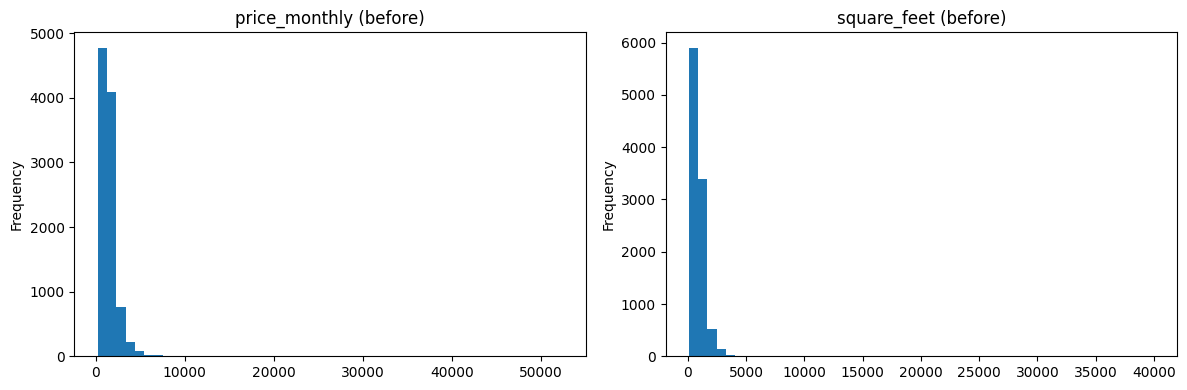

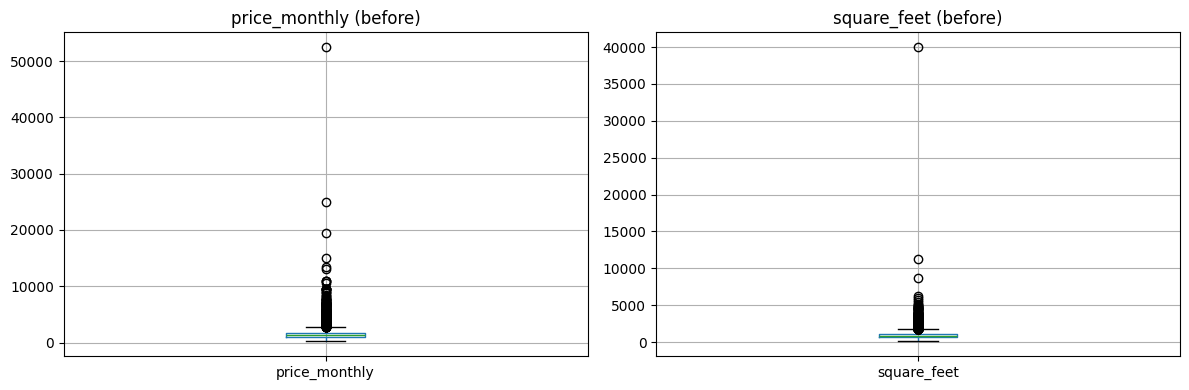

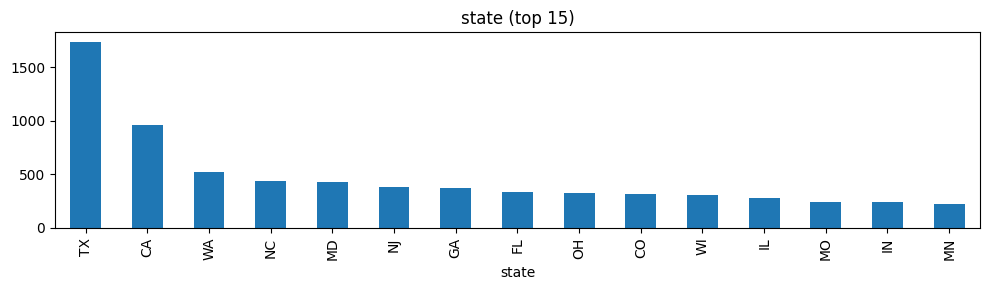

In [20]:
# Histograms
fig, axes = plt.subplots(1, 2, figsize=(12,4))
df_before["price_monthly"].dropna().plot(kind="hist", bins=50, ax=axes[0]); axes[0].set_title("price_monthly (before)")
if "square_feet" in df_before.columns:
    pd.to_numeric(df_before["square_feet"], errors="coerce").dropna().plot(kind="hist", bins=50, ax=axes[1]); axes[1].set_title("square_feet (before)")
plt.tight_layout(); plt.show()

# Boxplots
fig, axes = plt.subplots(1, 2, figsize=(12,4))
df_before[["price_monthly"]].boxplot(ax=axes[0]); axes[0].set_title("price_monthly (before)")
if "square_feet" in df_before.columns:
    pd.to_numeric(df_before["square_feet"], errors="coerce").to_frame().boxplot(ax=axes[1]); axes[1].set_title("square_feet (before)")
plt.tight_layout(); plt.show()

# Categorical top-15 bar
for cat in ["state", "cityname", "region"]:
    if cat in df_before.columns:
        vc = df_before[cat].astype(str).value_counts().head(15)
        ax = vc.plot(kind="bar", figsize=(10,3)); ax.set_title(f"{cat} (top 15)"); plt.tight_layout(); plt.show()
        break

### 5) Derived features & ABT (Analytics Base Table)

In [21]:
df_clean = df_before.copy()

# Binary encodings
for col in ["fee", "has_photo"]:
    if col in df_clean.columns:
        df_clean[col] = (df_clean[col].astype(str).str.lower()
                         .map({"yes":1,"no":0,"thumbnail":1}).fillna(0).astype(int))

# Pets flags
if "pets_allowed" in df_clean.columns:
    lower = df_clean["pets_allowed"].fillna("").astype(str).str.lower()
    df_clean["pet_cat_allowed"] = lower.str.contains("cat").astype(int)
    df_clean["pet_dog_allowed"] = lower.str.contains("dog").astype(int)

# Amenity count
if "amenities" in df_clean.columns:
    df_clean["amenity_count"] = df_clean["amenities"].fillna("").apply(lambda x: len(str(x).split(","))).astype(int)

# price_per_sqft
if "square_feet" in df_clean.columns:
    sf = pd.to_numeric(df_clean["square_feet"], errors="coerce")
    df_clean["price_per_sqft"] = df_clean["price_monthly"] / sf.replace(0, np.nan)

# ABT: drop text-heavy/IDs
abt_drop = ["id","title","body","address","amenities","price_display","price","price_type","currency","source"]
df_abt = df_clean.drop(columns=[c for c in abt_drop if c in df_clean.columns], errors="ignore")

print("ABT candidate shape:", df_abt.shape)
df_abt.head(3)

ABT candidate shape: (10000, 17)


,category,bathrooms,bedrooms,fee,has_photo,pets_allowed,square_feet,cityname,state,latitude,longitude,time,price_monthly,pet_cat_allowed,pet_dog_allowed,amenity_count,price_per_sqft
0,housing/rent/apartment,NaN,0.0,0,1,NaN,101,Washington,DC,38.9057,-76.9861,1577359415,790.0,0,0,1,7.821782
1,housing/rent/apartment,NaN,1.0,0,1,NaN,106,Evansville,IN,37.9680,-87.6621,1577017063,425.0,0,0,1,4.009434
2,housing/rent/apartment,1.0,0.0,0,1,NaN,107,Arlington,VA,38.8910,-77.0816,1577359410,1390.0,0,0,1,12.990654


### 6) Preprocess (filters, missing values, outliers)

In [22]:
df_proc = df_abt.copy()

# currency (if available in raw)
if "currency" in df_raw.columns:
    mask_usd = df_raw["currency"].astype(str).str.upper().eq("USD") | df_raw["currency"].isna()
    # align by index intersection
    df_proc = df_proc.loc[df_proc.index.intersection(mask_usd[mask_usd].index)]

# coords validity
if {"latitude", "longitude"}.issubset(df_proc.columns):
    lat = pd.to_numeric(df_proc["latitude"], errors="coerce")
    lon = pd.to_numeric(df_proc["longitude"], errors="coerce")
    good = lat.between(-90, 90) & lon.between(-180, 180) & ~((lat.abs()<0.1) & (lon.abs()<0.1))
    df_proc = df_proc[good]

# square feet sanity
if "square_feet" in df_proc.columns:
    sf = pd.to_numeric(df_proc["square_feet"], errors="coerce")
    df_proc = df_proc[(sf.isna()) | ((sf >= 120) & (sf <= 8000))]

# outliers: top 0.5%
q995 = df_proc["price_monthly"].quantile(0.995)
df_proc = df_proc[df_proc["price_monthly"] <= q995]

# fill numeric NaNs
for c in df_proc.select_dtypes(include=[np.number]).columns:
    df_proc[c] = df_proc[c].fillna(df_proc[c].median())

# drop duplicates
if "id" in df_raw.columns and "id" in df_proc.columns:
    df_proc = df_proc.drop_duplicates(subset=["id"])
else:
    df_proc = df_proc.drop_duplicates()

print("Processed shape:", df_proc.shape)
df_proc.head(3)

Processed shape: (9925, 17)


,category,bathrooms,bedrooms,fee,has_photo,pets_allowed,square_feet,cityname,state,latitude,longitude,time,price_monthly,pet_cat_allowed,pet_dog_allowed,amenity_count,price_per_sqft
4,housing/rent/apartment,1.0,0.0,0,1,NaN,125,Arlington,VA,38.8738,-77.1055,1577359401,880.0,0,0,1,7.040000
5,housing/rent/apartment,1.0,0.0,0,1,NaN,130,Manhattan,NY,40.7629,-73.9885,1577289784,2475.0,0,0,5,19.038462
6,housing/rent/apartment,1.0,0.0,0,1,NaN,132,Venice,CA,33.9932,-118.4609,1577359461,1800.0,0,0,1,13.636364


### 7) Distributions (AFTER preprocessing)

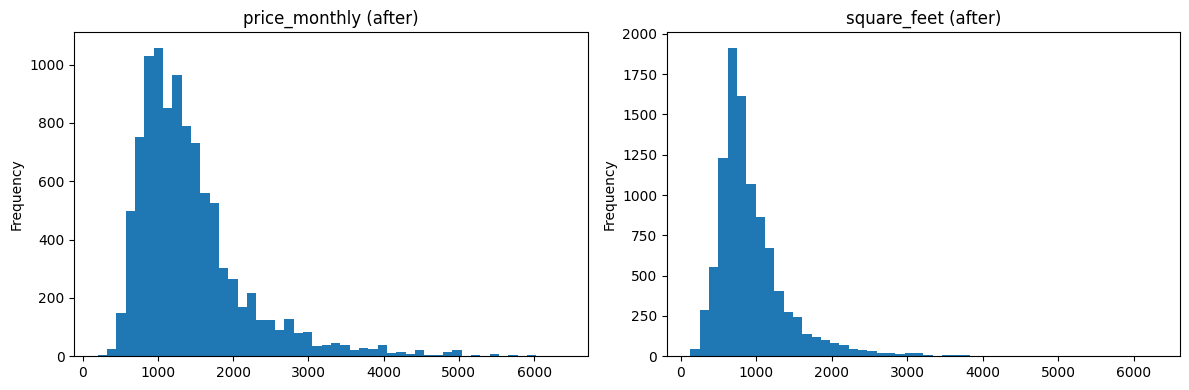

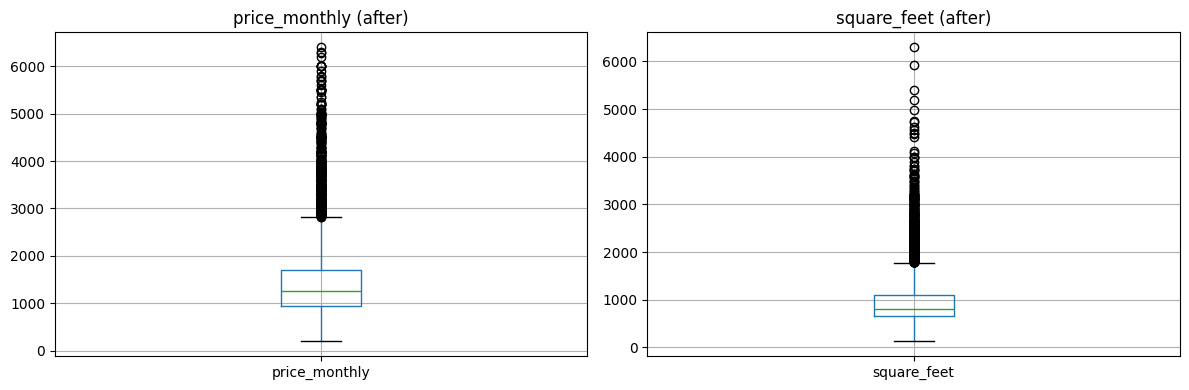

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
df_proc["price_monthly"].dropna().plot(kind="hist", bins=50, ax=axes[0]); axes[0].set_title("price_monthly (after)")
if "square_feet" in df_proc.columns:
    pd.to_numeric(df_proc["square_feet"], errors="coerce").dropna().plot(kind="hist", bins=50, ax=axes[1]); axes[1].set_title("square_feet (after)")
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
df_proc[["price_monthly"]].boxplot(ax=axes[0]); axes[0].set_title("price_monthly (after)")
if "square_feet" in df_proc.columns:
    pd.to_numeric(df_proc["square_feet"], errors="coerce").to_frame().boxplot(ax=axes[1]); axes[1].set_title("square_feet (after)")
plt.tight_layout(); plt.show()

### 8) Train/Val/Test split (70/15/15) and standardization demo (for KNN)

Shapes: (6947, 12) (1489, 12) (1489, 12)


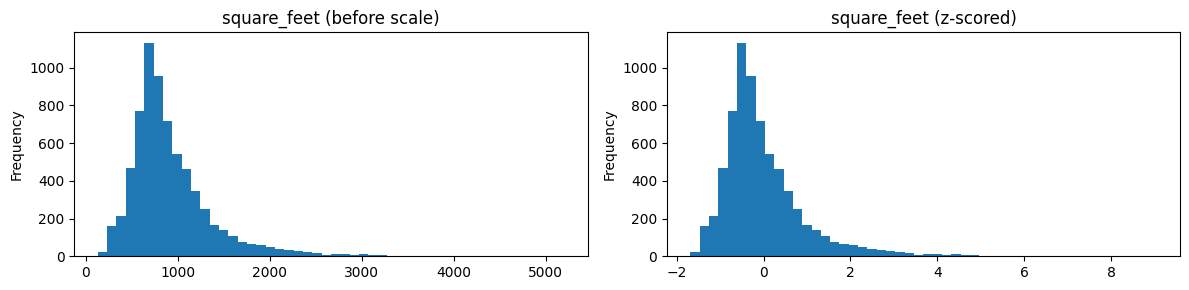

In [24]:
y = df_proc["price_monthly"].astype(float)
X = df_proc.drop(columns=["price_monthly"])

# Keep only numeric features for modeling (sklearn estimators require numeric dtypes)
X = X.select_dtypes(include=[np.number])

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1765, random_state=42)

scaler = StandardScaler()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols]   = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# show before vs after scaling (if available)
cand = [c for c in ["square_feet","price_per_sqft","bedrooms","bathrooms"] if c in num_cols]
if cand:
    v = cand[0]
    fig, axes = plt.subplots(1,2, figsize=(12,3))
    X_train[v].plot(kind="hist", bins=50, ax=axes[0]); axes[0].set_title(f"{v} (before scale)")
    pd.Series(X_train_scaled[v]).plot(kind="hist", bins=50, ax=axes[1]); axes[1].set_title(f"{v} (z-scored)")
    plt.tight_layout(); plt.show()

## P2–P3. Modeling and hyperparameter selection

In [25]:
def eval_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE_%": mean_absolute_percentage_error(y_true, y_pred)*100,
        "RMSE": np.sqrt(((y_true - y_pred)**2).mean()),
        "R2": r2_score(y_true, y_pred)
    }

all_results = []

# Baseline (mean)
baseline_val = np.full_like(y_val, y_train.mean())
m = eval_metrics(y_val, baseline_val)
all_results.append({"model":"Baseline","params":"mean(y_train)","split":"Val", **m})

# KNN (scaled)
for k in [3,5,10]:
    mdl = KNeighborsRegressor(n_neighbors=k)
    mdl.fit(X_train_scaled, y_train)
    for split, X_, y_ in [("Train", X_train_scaled, y_train), ("Val", X_val_scaled, y_val)]:
        pred = mdl.predict(X_)
        all_results.append({"model":"KNN","params":f"k={k}","split":split, **eval_metrics(y_, pred)})

# Decision Tree
for depth in [5,10,None]:
    for leaf in [1,5,10]:
        mdl = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=leaf, random_state=42)
        mdl.fit(X_train, y_train)
        for split, X_, y_ in [("Train", X_train, y_train), ("Val", X_val, y_val)]:
            pred = mdl.predict(X_)
            all_results.append({"model":"DecisionTree","params":f"depth={depth},leaf={leaf}","split":split, **eval_metrics(y_, pred)})

# Random Forest
for n in [50,100,200]:
    for leaf in [1,2]:
        mdl = RandomForestRegressor(n_estimators=n, min_samples_leaf=leaf, random_state=42, n_jobs=-1)
        mdl.fit(X_train, y_train)
        for split, X_, y_ in [("Train", X_train, y_train), ("Val", X_val, y_val)]:
            pred = mdl.predict(X_)
            all_results.append({"model":"RandomForest","params":f"n={n},leaf={leaf}","split":split, **eval_metrics(y_, pred)})

results_df = pd.DataFrame(all_results)
print("Validation results (best 6 per model by MAE):")
display(results_df[results_df["split"]=="Val"].sort_values(["model","MAE"]).groupby("model").head(6))

Validation results (best 6 per model by MAE):


,model,params,split,MAE,MAPE_%,RMSE,R2
0,Baseline,mean(y_train),Val,527.357320,40.728604,773.656751,-0.000041
20,DecisionTree,"depth=None,leaf=1",Val,43.083277,2.350527,116.430107,0.977351
22,DecisionTree,"depth=None,leaf=5",Val,46.206645,2.594262,116.647987,0.977266
14,DecisionTree,"depth=10,leaf=1",Val,55.182832,3.313764,123.127805,0.974670
16,DecisionTree,"depth=10,leaf=5",Val,55.538364,3.363030,120.467825,0.975753
24,DecisionTree,"depth=None,leaf=10",Val,60.649611,3.461653,146.809135,0.963990
18,DecisionTree,"depth=10,leaf=10",Val,65.569190,3.871308,148.597436,0.963107
2,KNN,k=3,Val,187.910529,12.768617,308.170793,0.841327
4,KNN,k=5,Val,195.841818,13.283267,321.116252,0.827716
6,KNN,k=10,Val,210.153302,14.147916,346.673516,0.799201


In [26]:
best = {}
for mdl in results_df["model"].unique():
    sub = results_df[(results_df["model"]==mdl) & (results_df["split"]=="Val")]
    if len(sub)==0: continue
    best[mdl] = sub.sort_values("MAE").iloc[0]["params"]
best

{'Baseline': 'mean(y_train)',
 'KNN': 'k=3',
 'DecisionTree': 'depth=None,leaf=1',
 'RandomForest': 'n=200,leaf=2'}

In [27]:
# Retrain best params on Train+Val, evaluate on Test
X_trv = pd.concat([X_train, X_val], axis=0)
y_trv = pd.concat([y_train, y_val], axis=0)
X_trv_scaled = pd.concat([X_train_scaled, X_val_scaled], axis=0)

final = []

# Baseline
baseline_test = np.full_like(y_test, y_trv.mean())
final.append({"model":"Baseline","params":"mean(tr+val)","split":"Test", **eval_metrics(y_test, baseline_test)})

# KNN
if "KNN" in best:
    k = int(best["KNN"].split("=")[1])
    mdl = KNeighborsRegressor(n_neighbors=k).fit(X_trv_scaled, y_trv)
    final.append({"model":"KNN","params":best["KNN"],"split":"Test", **eval_metrics(y_test, mdl.predict(X_test_scaled))})

# Decision Tree
if "DecisionTree" in best:
    parts = dict(p.split("=") for p in best["DecisionTree"].split(","))
    depth = None if parts["depth"]=="None" else int(parts["depth"])
    leaf = int(parts["leaf"])
    mdl = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=leaf, random_state=42).fit(X_trv, y_trv)
    final.append({"model":"DecisionTree","params":best["DecisionTree"],"split":"Test", **eval_metrics(y_test, mdl.predict(X_test))})

# Random Forest
if "RandomForest" in best:
    parts = dict(p.split("=") for p in best["RandomForest"].split(","))
    n = int(parts["n"]); leaf = int(parts["leaf"])
    mdl = RandomForestRegressor(n_estimators=n, min_samples_leaf=leaf, random_state=42, n_jobs=-1).fit(X_trv, y_trv)
    final.append({"model":"RandomForest","params":best["RandomForest"],"split":"Test", **eval_metrics(y_test, mdl.predict(X_test))})

final_df = pd.DataFrame(final)
print("Final Test metrics:")
display(final_df)

Final Test metrics:


,model,params,split,MAE,MAPE_%,RMSE,R2
0,Baseline,mean(tr+val),Test,514.106405,42.038882,719.624367,-0.000508
1,KNN,k=3,Test,188.338034,13.097229,313.658382,0.809926
2,DecisionTree,"depth=None,leaf=1",Test,37.458026,2.350066,92.994403,0.983292
3,RandomForest,"n=200,leaf=2",Test,15.102608,0.999380,47.876916,0.995571


### Random Forest feature importances (optional)

In [28]:
if "RandomForest" in best:
    parts = dict(p.split("=") for p in best["RandomForest"].split(","))
    n = int(parts["n"]); leaf = int(parts["leaf"])
    mdl = RandomForestRegressor(n_estimators=n, min_samples_leaf=leaf, random_state=42, n_jobs=-1)\
            .fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
    imp = pd.DataFrame({"feature": X_train.columns, "importance": mdl.feature_importances_})\
            .sort_values("importance", ascending=False)
    display(imp.head(20))

,feature,importance
4,square_feet,0.528054
11,price_per_sqft,0.452620
6,longitude,0.013706
5,latitude,0.003791
7,time,0.000870
10,amenity_count,0.000282
1,bedrooms,0.000228
0,bathrooms,0.000173
9,pet_dog_allowed,0.000140
8,pet_cat_allowed,0.000135


---
### References (for convenience)
- KNN (scikit-learn): https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html  
- Decision Trees (scikit-learn): https://scikit-learn.org/stable/modules/tree.html  
- Random Forest (scikit-learn): https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html  
- Dataset: https://archive.ics.uci.edu/dataset/555/apartment+for+rent+classified
